In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy
from hmmlearn import hmm
import warnings
import pickle
import os  

In [2]:
#data loading
home="./weather_romania"

#get filenames
filenames=sorted(os.listdir(home)) #get all files in folder 
csv_data=[] #list for csv files 
for file in filenames:
    if file.endswith(".csv"):  #if file has csv extension add it to list of csv data
        csv_data.append(file)
data=[]
#create the dataframes of the weather stations data
for file in filenames:
    data.append(pd.read_csv(f"{home}/{file}"))

### Weather data of some stations in Romania for the period 2011-2021

In [3]:
#recap of data available (all dataframes are analogous)
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date time            4018 non-null   object 
 1   Minimum Temperature  4018 non-null   float64
 2   Maximum Temperature  4018 non-null   float64
 3   Relative Humidity    4018 non-null   float64
 4   Wind Speed           4018 non-null   float64
 5   Precipitation        4018 non-null   float64
 6   Cloud Cover          4018 non-null   float64
 7   Sea Level Pressure   4018 non-null   float64
 8   Latitude             4018 non-null   float64
 9   Longitude            4018 non-null   float64
dtypes: float64(9), object(1)
memory usage: 314.0+ KB


In [4]:
#save the names of stations
for i in range(len(data)):
      filenames[i]=filenames[i].replace(".csv", "")

In [5]:
#data cleaning, normalize rain and add day column
for i in range(len(data)):
    data[i]["Precipitation"]=np.log(data[i]["Precipitation"]+0.01)
    data[i].insert(0, "day", np.arange(len(data[i]))) #day columns)
    data[i]=data[i].astype({"day": float})
    data[i]=data[i].astype({"day": float})

# Gaussian process

# Kirging: interpolate unknown stations based on weather in others, this work on the single day. 

### Have 42 stations, select 32 randomly for training and use others as test

In [6]:
#select randomly the train stations, and use the remaining for test
random.seed(5)
train_stations_list=sorted(random.sample(range(42), 32))
test_stations_list=list(set(range(42)).symmetric_difference(set(train_stations_list)))

#create the train/test dataframes with first day
train=[]
for i in train_stations_list:
    train.append(data[i].loc[0:0,:])
train=pd.concat(train)

test=[]
for i in test_stations_list:
    test.append(data[i].loc[0:0,:])
test=pd.concat(test)

train_test=pd.concat([train, test])#just for plotting reason (to have all spatial data in one dataframe)

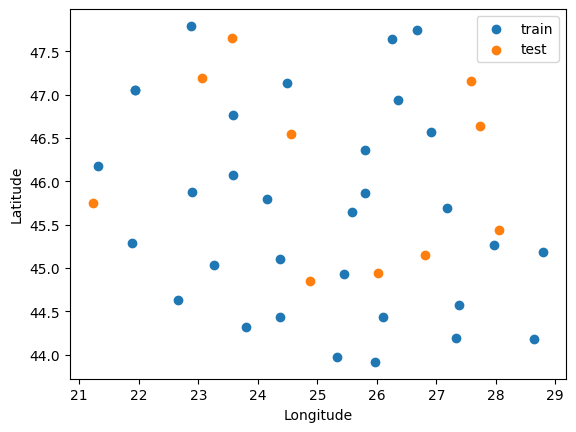

In [7]:
#map of relative positions of stations
plt.scatter(train.loc[:,"Longitude"], train.loc[:,"Latitude"], label="train")
plt.scatter(test.loc[:,"Longitude"], test.loc[:,"Latitude"], label="test")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [9]:
train_feature=["Latitude", "Longitude"] #"Wind Speed", "Sea Level Pressure"]#, "Latitude", "Longitude"]
target_feature=["Minimum Temperature"]

import gpflow
from gpflow.kernels import RBF, Periodic, Coregion, Matern12, Cosine, White, Linear, Matern52, RationalQuadratic, Matern32

# Define the temporal kernel 

space_kernel1=Linear()
#space_kernel2=Matern32()
space_kernel3=RationalQuadratic()

space_kernel_tot=space_kernel1+space_kernel3#+space_kernel3
noise=White(variance=0.3**2)

#Composite kernel
kernel = (space_kernel_tot+noise) 

In [9]:
model = gpflow.models.GPR((train[train_feature].values, train[target_feature].values), kernel=kernel)

def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="L-BFGS-B",
        options={"disp": 1, "maxiter": 150},   
    )
    
#recap
model

<gpflow.models.gpr.GPR object at 0x74f9b210fd00>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].alpha        │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[2].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    0.09 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    1    │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [10]:
#Optimize the model
optimize_model_with_scipy(model)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58020D+01    |proj g|=  9.22183D+00

At iterate    1    f=  7.73136D+01    |proj g|=  3.35358D+00

At iterate    2    f=  7.51760D+01    |proj g|=  2.00663D+00

At iterate    3    f=  7.39451D+01    |proj g|=  9.68481D-01

At iterate    4    f=  7.31023D+01    |proj g|=  6.63303D-01

At iterate    5    f=  7.16405D+01    |proj g|=  7.99266D-01

At iterate    6    f=  7.05021D+01    |proj g|=  9.18893D-01

At iterate    7    f=  7.02911D+01    |proj g|=  4.68651D-01

At iterate    8    f=  7.02354D+01    |proj g|=  3.40413D-01

At iterate    9    f=  7.01610D+01    |proj g|=  1.41925D-01

At iterate   10    f=  7.01494D+01    |proj g|=  1.17577D-01

At iterate   11    f=  7.01367D+01    |proj g|=  1.25202D-01

At iterate   12    f=  7.01041D+01    |proj g|=  2.50532D-01

At iterate   13    f=  7.0

 This problem is unconstrained.


In [11]:
#run only once to save the models
#file_path = 'GP_kriging.pickle'
# Open the file in binary mode
#with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
#    pickle.dump(model, file)

In [10]:
file_path = 'GP_kriging.pickle'
# Open the file in binary mode
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    model = pickle.load(file)

In [11]:
#recap of optimization
model

<gpflow.models.gpr.GPR object at 0x704d494150a0>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      0.0266466 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      4.74994   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      0.771342  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[1].alpha        │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 745770         │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[2].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      0.998909  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │      1e-06     │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════╛

In [12]:
#to get the infered values of new stations
mean, var = model.predict_f(test[train_feature].values)

#convert to numpy object
mean=np.array(mean)
var=np.array(var)

pred = pd.DataFrame({
    'Latitude':test["Latitude"].values.flatten(),
    'Longitude': test["Longitude"].values.flatten(),
    'True Temperature':test[target_feature].values.flatten(),
    'Interpolated Temperature': mean.flatten(),
    'Variance': var.flatten(),
    'absolute error':np.abs(test[target_feature].values-np.array(mean)).flatten()

})

pred

Latitude  Longitude  True Temperature  Interpolated Temperature  Variance  \
0   47.6572    23.5660              -6.1                 -8.032682  3.198266   
1   45.1511    26.8174             -11.2                -11.043236  2.679019   
2   45.4337    28.0548             -10.3                -10.183949  1.874984   
3   47.1594    27.5873              -7.8                 -7.841039  4.515648   
4   44.8515    24.8799              -8.3                 -9.077781  1.864657   
5   44.9407    26.0233             -10.0                -10.136955  2.083504   
6   46.5426    24.5580             -10.0                -10.599646  2.663611   
7   45.7534    21.2233             -11.8                 -9.400043  2.464442   
8   46.6385    27.7331              -8.2                 -8.694581  4.389910   
9   47.1878    23.0579              -7.3                 -7.850125  2.430556   

   absolute error  
0        1.932682  
1        0.156764  
2        0.116051  
3        0.041039  
4        0.777781  
5        0.136955  
6        0.599646  
7        2.399957  
8        0.494581  
9        0.550125

In [13]:
#mean absolute percentage error (MAPE)
MAE=np.abs(test[target_feature].values-np.array(mean)).mean()
MAE

0.7205581293280973

### TO STUDY THE SPATIAL DISTRIBUTION

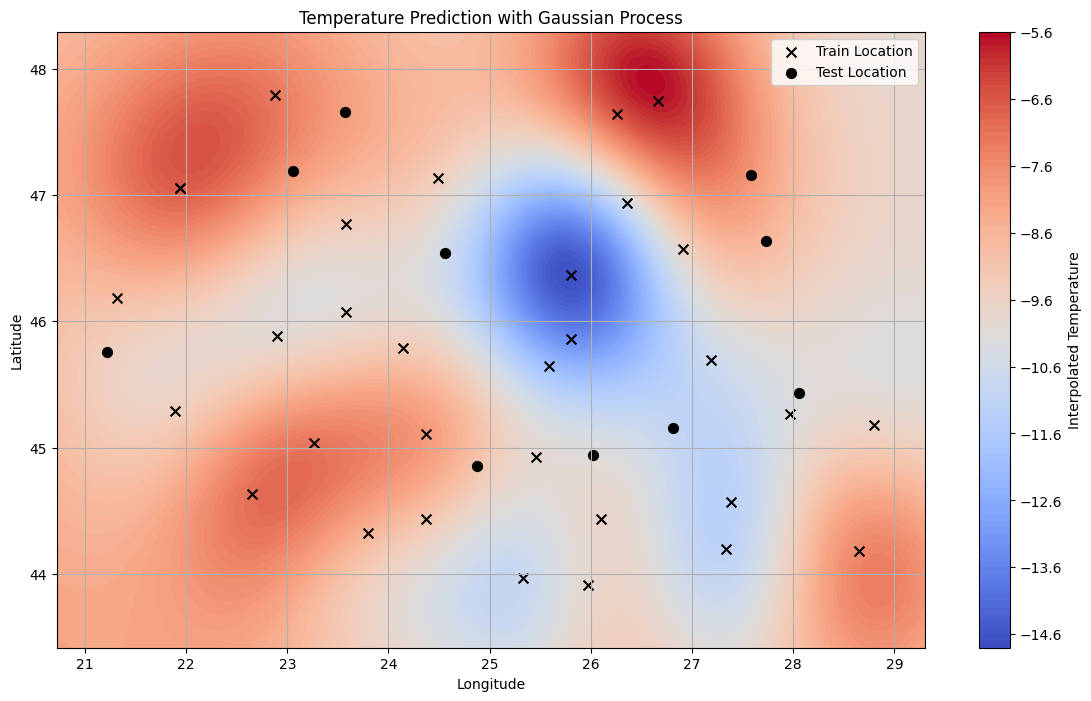

In [20]:
# Generate a grid of latitude and longitude values
lat_range = np.linspace(min(train_test["Latitude"])-0.5, max(train_test["Latitude"])+0.5, 120)
lon_range = np.linspace(min(train_test["Longitude"])-0.5, max(train_test["Longitude"])+0.5, 120)
lat_grid, lon_grid = np.meshgrid(lat_range, lon_range)
grid_points = np.c_[lat_grid.ravel(), lon_grid.ravel()]

# Predict the mean and variance over the grid
mean, var = model.predict_f(grid_points)

# Reshape the predictions back into a grid for plotting
mean_grid = mean.numpy().reshape(lat_grid.shape)
var_grid = var.numpy().reshape(lat_grid.shape)

# Calculate confidence intervals (95% CI)
lower_ci = mean_grid - 1.96 * np.sqrt(var_grid)
upper_ci = mean_grid + 1.96 * np.sqrt(var_grid)

# Plot the mean prediction
plt.figure(figsize=(14, 8))
plt.contourf(lon_grid, lat_grid, mean_grid, cmap='coolwarm', levels=100)
plt.colorbar(label='Interpolated Temperature')
plt.scatter(train["Longitude"], train["Latitude"], c='black', s=50, marker='x', label='Train Location')
plt.scatter(test["Longitude"], test["Latitude"], c='black', s=50, marker='o', label='Test Location')
plt.title("Temperature Prediction with Gaussian Process")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

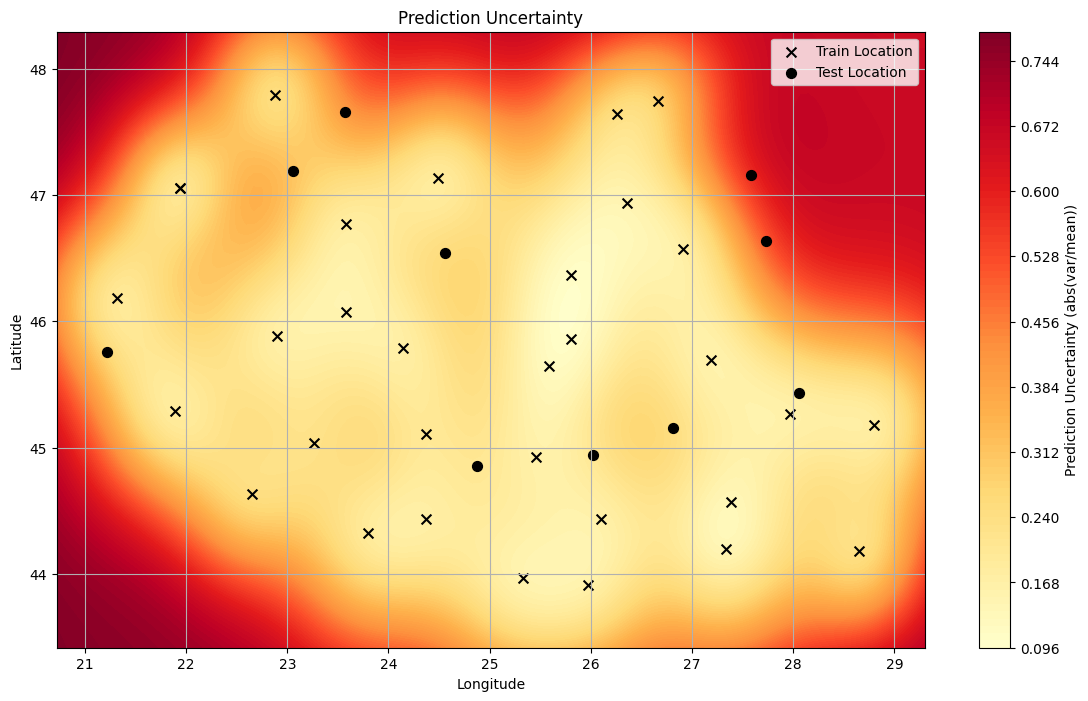

In [21]:

#Plot the uncertainty (variance) or confidence intervals
plt.figure(figsize=(14, 8))
plt.contourf(lon_grid, lat_grid, abs(var_grid/mean_grid), cmap='YlOrRd', levels=100)
plt.colorbar(label='Prediction Uncertainty (abs(var/mean))')
plt.scatter(train["Longitude"], train["Latitude"], c='black', s=50, marker='x', label='Train Location')
plt.scatter(test["Longitude"], test["Latitude"], c='black', s=50, marker='o', label='Test Location')
plt.title("Prediction Uncertainty")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

### THE FARTHEST FROM TRAINING POINT THE HIGHER THE UNCERTAINTY

### THE DISTRIBUTION OF THE TRAINING POINT WILL HAVE AN IMPACT ON THE QUALITY OF INTERPOLATION ON TEST POINT, FOR EXAMPLE THE TWO POINT AT NORTH-EAST WILL LIKELY HAVE A BIGGER ERROR THAN THE CENTRAL ONES.

# check if the model can be used for everiday or have to be updated periodically
# to check plot the MAE in function of the day

In [17]:
#daily interpolation
MAE=[]
for i in tqdm(range(366)):
    #create test set
    test=[]
    for j in test_stations_list: #try to find a more efficient way? (i actually measured this cycle at just 1ms)
        test.append(data[j].loc[i:i,:])
    test=pd.concat(test)
    mean, var = model.predict_f(test[train_feature].values) #this should be the command that slow the cycle, can't be enhanced    
    #compute the MAE
    MAE.append(np.abs(test[target_feature].values-np.array(mean)).mean())

100%|█████████████████████████████████████████| 366/366 [00:23<00:00, 15.72it/s]


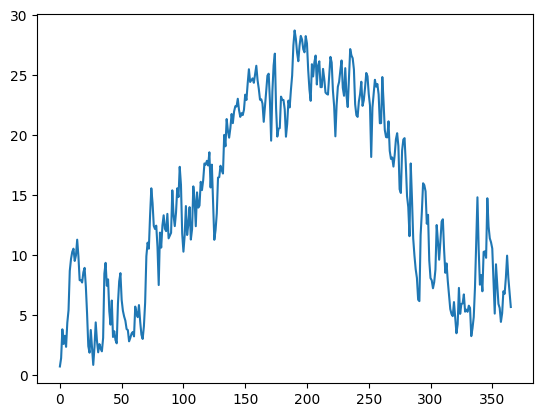

In [18]:
plt.plot(np.arange(366), MAE)

### THE MAE IS ACCEPTABLE ONLY FOR THE FIRST DAY, FOLLOWING DAY IT STARTS INCREASING

### THIS MEANS THAT DEPENDENCIES ARE GOOD FOR THE DAY AND THEN CHANGE


### IN SUMMER MAE IS OVER 20 BECAUSE IT KEEPS PREDICTING NEGATIVE TEMPERATURE, THE MAE IS BAD ALSO IN FOLLOWING WINTER MEANING THAT DEPENDENCIES CHANGES EVEN WITH SIMILAR TEMPERATURE

In [10]:
#new train function(just to deactivate verbose)
def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="L-BFGS-B",
        options={"disp": 0, "maxiter": 150},   
    )

In [22]:
#performance check by training a new GP for each day
MAE=[]
for i in tqdm(range(366)):
    #create the train set
    train=[]
    for j in train_stations_list:
        train.append(data[j].loc[i:i,:])
    train=pd.concat(train)
    
    #create test set
    test=[]
    for j in test_stations_list: 
        test.append(data[j].loc[i:i,:])
    test=pd.concat(test)
    
    #define and optimize the model for the day
    space_kernel1=Linear()
    #space_kernel2=Matern32()
    space_kernel3=RationalQuadratic()

    space_kernel_tot=space_kernel1+space_kernel3#+space_kernel3
    noise=White(variance=0.3**2)
    
    kernel = (space_kernel_tot+noise)#Composite kernel 
    model = gpflow.models.GPR((train[train_feature].values, train[target_feature].values), kernel=kernel)
    optimize_model_with_scipy(model)
        
    mean, var = model.predict_f(test[train_feature].values)     
    #compute the MAPE
    MAE.append(np.abs(test[target_feature].values-np.array(mean)).mean())

100%|█████████████████████████████████████████| 366/366 [04:29<00:00,  1.36it/s]


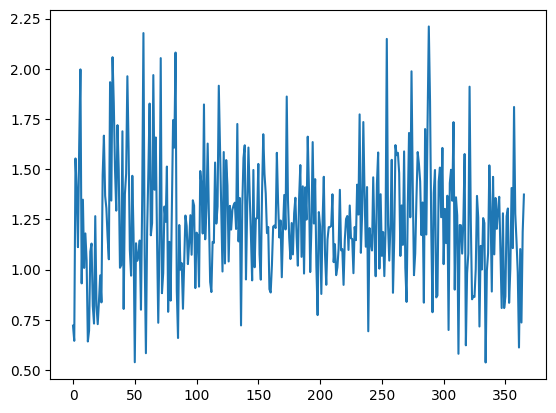

In [23]:
plt.plot(np.arange(366), MAE)

In [26]:
MMAE=sum(MAE)/len(MAE)
MMAE

1.2352109620315572

### THE MAE IS OBSCILLATING BETWEEN 0.5 AND 2.25, IT HAS MEAN 1.23.
### THESE ARE PRETTY GOOD VALUES.

# DO THE SAME GRAPH UPDATING THE MODEL EVERY 2/3 DAYS, THIS WAY IT IS POSSIBLE TO KNOW WETHER USING THE MODEL OF A DAY ON FORECASTED DATA OF THE NEXT IS FEASIBLE

In [11]:
#performance check by training a new GP for every two days
MAE=[]
for i in tqdm(range(366)):
    #create the train set
    train=[]
    for j in train_stations_list:
        train.append(data[j].loc[i:i,:])
    train=pd.concat(train)
    
    #create test set
    test=[]
    for j in test_stations_list: 
        test.append(data[j].loc[i:i,:])
    test=pd.concat(test)
    
    #update the model every two days
    if (i%2==0):
        #define and optimize the model for the day
        space_kernel1=Linear()
        #space_kernel2=Matern32()
        space_kernel3=RationalQuadratic()

        space_kernel_tot=space_kernel1+space_kernel3#+space_kernel3
        noise=White(variance=0.3**2)
    
        kernel = (space_kernel_tot+noise)#Composite kernel 
        model = gpflow.models.GPR((train[train_feature].values, train[target_feature].values), kernel=kernel)
        optimize_model_with_scipy(model)
        
    mean, var = model.predict_f(test[train_feature].values)     
    #compute the MAPE
    MAE.append(np.abs(test[target_feature].values-np.array(mean)).mean())

100%|█████████████████████████████████████████| 366/366 [02:32<00:00,  2.40it/s]


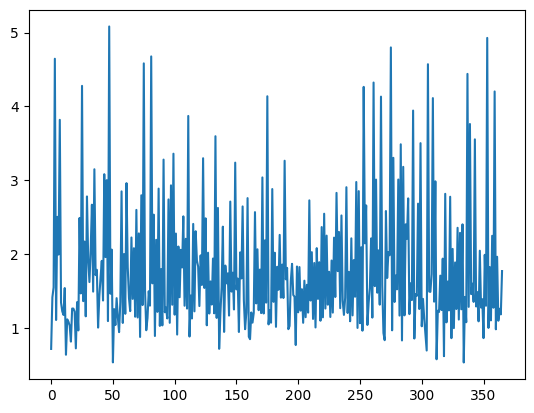

In [12]:
plt.plot(np.arange(366), MAE)

### WORSE THAN THE DAILY, BUT ACCEPTABLE

### THE PEAKS DISTRIBUTION IS ANALOGOUS TO PREVIOUS CASE, BUT THEY ARE TWICE AS WORSE, THESE ARE DAYS FOR WHICH IT WOULD BE HARDER TO INTERPOLATE IN ANY CASE, (WITH ONLY THIS INFORMATION AVAILABLE)

### GPs SCALES CUBICALLY WITH DATA, SO IN THE CASE THERE WERE MORE WEATHER STATION TRAINING DAILY MODELS WOULD NOT BE FEASIBLE

### IT COULD BE THE CASE THAT THE SPATIAL DEPENDENCIES CHANGE BASED ON THE WEATHER, TRY TO USE HMM TO IDENTIFY WEATHER STATES AND TRAIN A GP FOR EACH SEPARATE STATE.

### IS IT POSSIBLE TO IDENTIFY A WEATHER STATE FOR THE WHOLE AREA USING ONLY MINIMUM TEMPERATURE

In [26]:
#Put all temperature data together
new_train_stations_list=list(set(train_stations_list)-set([5]))
temperature_df=[]

for i in new_train_stations_list:
    temperature_df.append(data[i]["Minimum Temperature"])
temperature_df=pd.concat(temperature_df, axis=1)

#rename columns
temperature_df.columns=[filenames[i] for i in new_train_stations_list]

temperature_df

alba_iulia  alexandria  arad  bacau  bistrita  botosani  braila  brasov  \
0          -10.1       -11.6  -9.0   -9.1      -9.3      -5.3   -10.1   -11.8   
1           -9.0        -6.9  -9.8   -9.2      -9.1      -8.4    -8.9   -12.4   
2           -7.2        -3.8  -4.3   -7.7      -8.1     -11.6    -3.7   -18.9   
3           -6.7        -5.5 -10.6  -15.0      -7.4     -15.9   -11.9   -19.9   
4          -11.5        -8.6 -11.9  -16.0     -12.5     -19.1   -10.6   -18.9   
...          ...         ...   ...    ...       ...       ...     ...     ...   
4013         2.6        -0.3  -0.8   -3.7       0.5      -4.2    -1.0    -0.8   
4014        -0.1         0.4   0.0   -5.7       0.3      -5.0    -3.1    -1.5   
4015         1.6        -0.8   2.8   -4.9       0.3      -5.4    -3.9    -2.2   
4016         2.8        -0.3   2.8   -3.8       1.6      -5.4    -1.2     1.3   
4017         3.6        -0.5   3.0   -3.2       2.3      -3.9    -0.3     1.2   

      bucharest  calarasi  ...  resita  satu_mare  sfantu_georghe  sibiu  \
0          -9.5     -11.8  ...    -9.7       -7.0           -13.3   -9.6   
1          -9.3      -9.6  ...    -9.7       -4.0           -11.5   -9.1   
2          -4.6      -8.8  ...    -5.6       -3.0           -14.6   -4.8   
3          -9.5      -9.4  ...   -10.6       -4.0           -18.2   -7.6   
4          -7.7      -9.9  ...   -11.7      -11.0           -16.0  -10.7   
...         ...       ...  ...     ...        ...             ...    ...   
4013       -0.7       0.6  ...     1.0       -3.6             0.1    1.6   
4014       -0.4      -0.9  ...    -0.1       -1.7            -0.9   -1.2   
4015       -1.2      -1.7  ...     2.6        0.8            -1.9    0.6   
4016        0.1       0.2  ...     2.6        0.8            -0.6    0.6   
4017        0.8       1.6  ...     2.5        1.1             1.2    1.0   

      slatina  slobozia  suceava  targoviste  targu_jiu  tulcea  
0        -8.9     -11.3     -5.9       -10.2       -6.6   -10.0  
1        -5.0      -9.2     -7.7        -9.9        0.6    -8.2  
2        -2.1      -6.8    -11.7        -8.8       -1.7    -5.6  
3        -5.4      -9.6    -11.1       -12.0       -1.9   -11.0  
4        -9.2     -11.0    -14.2       -11.3       -3.9   -12.2  
...       ...       ...      ...         ...        ...     ...  
4013     -0.2      -0.3     -4.8        -0.8        0.1    -0.9  
4014      0.1      -2.3     -5.6        -0.9       -0.5    -3.2  
4015     -0.5      -2.6     -5.7        -1.6        0.1    -3.2  
4016      0.0      -0.4     -4.8        -0.1       -0.2    -1.9  
4017      0.6       0.6     -2.2        -0.9        0.1    -1.2  

[4018 rows x 31 columns]

In [27]:
#use first 8? years to train 
train_hmm=temperature_df.loc[0:365*8,:]
#train=pd.concat(train)

test_hmm=temperature_df.loc[365*8:365*9,:].reset_index()
#test=pd.concat(test)
train_feature_hmm=temperature_df.columns.to_list()

In [10]:
model_hmm=[]  #list of models, the number of hidden states is different
hidden_states=[1,2,3,4,5,6,10,15,20] #number of hidden states to try


for i in hidden_states:
    model_hmm.append(hmm.GaussianHMM(n_components=i, n_iter=200, random_state=42, covariance_type = "diag", tol=1e-3))
    
#fit the models
for i in tqdm(range(len(model_hmm))):
    model_hmm[i].fit(train_hmm[train_feature_hmm].values)

100%|█████████████████████████████████████████████| 9/9 [00:23<00:00,  2.63s/it]


In [11]:
#run only once to save the models
file_path = 'gaussianhmm_process_t_state.pickle'
# Open the file in binary mode
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(model_hmm, file)

In [23]:
file_path = 'gaussianhmm_process_t_state.pickle'
# Open the file in binary mode
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    model_hmm = pickle.load(file)

In [28]:
hidden_states=[1,2,3,4,5,6,10,15,20] #number of hidden states to try
aic=[]
bic=[]
for i in range(len(model_hmm)):
    aic.append(model_hmm[i].aic(train_hmm[train_feature_hmm].values))
    bic.append(model_hmm[i].bic(train_hmm[train_feature_hmm].values))

best_aic=np.argmin(aic)
best_bic=np.argmin(bic)
print(f'Best number of hidden states according to AIC {hidden_states[best_aic]}')
print(f'Best number of hidden states according to BIC {hidden_states[best_bic]}')

Best number of hidden states according to AIC 20
Best number of hidden states according to BIC 20


### THIS WAS DONE USING ONLY THE TEMPERATURE, SO THE STATES ARE  ALMOST ONLY ON MEAN TEMPERATURE RANGES, MAYBE SOME OTHER DEPENDENCIES ARE CAUGHT


Model convergence:
True

Gaussian distribution means:
[[ 5.100e+00  7.700e+00  5.850e+00  6.340e+00  4.350e+00  6.120e+00
   8.150e+00 -8.400e-01  8.130e+00  8.200e+00  4.740e+00  1.009e+01
   7.460e+00  5.260e+00  8.350e+00  7.550e+00  7.660e+00  9.500e-01
   5.730e+00  3.450e+00  7.100e+00  6.100e+00  4.650e+00  7.700e-01
   4.270e+00  7.420e+00  7.990e+00  5.520e+00  4.840e+00  6.830e+00
   8.590e+00]
 [-1.734e+01 -1.883e+01 -1.316e+01 -1.751e+01 -1.659e+01 -1.855e+01
  -1.605e+01 -2.212e+01 -1.721e+01 -1.571e+01 -1.669e+01 -1.156e+01
  -1.650e+01 -1.475e+01 -1.266e+01 -1.542e+01 -1.794e+01 -2.400e+01
  -1.247e+01 -1.758e+01 -1.488e+01 -1.355e+01 -1.433e+01 -2.233e+01
  -1.928e+01 -1.713e+01 -1.576e+01 -1.696e+01 -1.875e+01 -1.424e+01
  -1.409e+01]
 [-2.320e+00 -2.400e-01 -9.500e-01 -1.650e+00 -2.870e+00 -1.770e+00
  -1.600e-01 -9.210e+00 -3.900e-01  2.100e-01 -2.820e+00  2.160e+00
  -4.600e-01 -1.780e+00  7.800e-01 -5.200e-01 -4.900e-01 -6.350e+00
  -1.030e+00 -4.980e+00 -7.800e-0

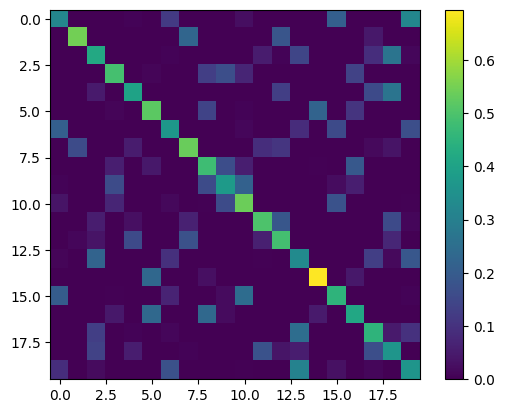

In [13]:
print("\nModel convergence:")
print(model_hmm[best_bic].monitor_.converged) 


print("\nGaussian distribution means:")
print(np.round(model_hmm[best_bic].means_, 2))

print("\nGaussian distribution covariances:")
print(np.round(model_hmm[best_bic].covars_, 2))

print("\nStart probabilities:")
print(np.round(model_hmm[best_bic].startprob_, 2))

print("\nTransition matrix:")
print(np.round(model_hmm[best_bic].transmat_,2))

_ = plt.imshow(model_hmm[best_bic].transmat_)
_ = plt.colorbar()

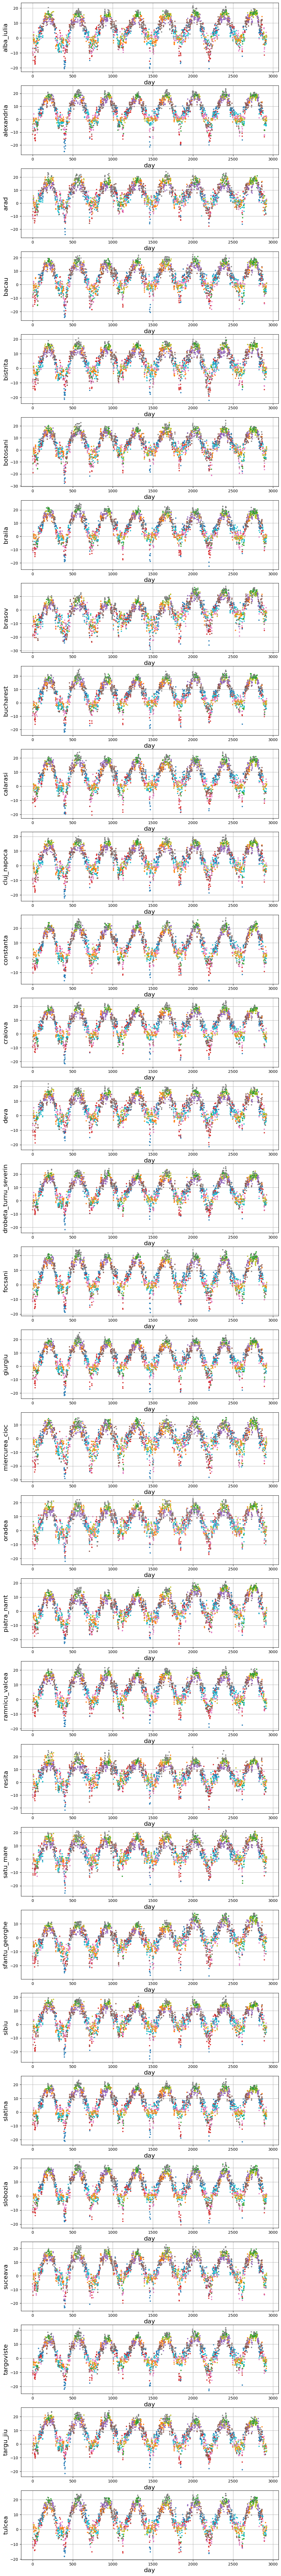

In [29]:
#Plot the most probable hidden state sequence of the train set
Z = model_hmm[best_bic].predict(train_hmm[train_feature_hmm].values) # Find most probable hidden states sequence
Z_prob = model_hmm[best_bic].predict_proba(train_hmm[train_feature_hmm].values) # Find most probable hidden states sequence
plt.figure(figsize = (12, 120))

STATES = np.unique(Z)

for i, col in enumerate(train_feature_hmm):
    plt.subplot(len(train_feature_hmm),1,i+1)
    plt.scatter(np.arange(len(train_hmm)), train_hmm[col], c = Z, alpha=0.9, cmap = "tab10", s = 6)
    plt.grid(True)
    plt.xlabel("day", fontsize=16)
    plt.ylabel(col, fontsize=16)

### DEFINE A DIFFERENT MODEL FOR EACH STATE, SEE IF IT CAN BE USED TO MAKE INTERPOLATION...

In [15]:
#These are the most probable hidden states sequence of train set, and simulated hidden states sequence of test set
Z = model_hmm[best_bic].predict(train_hmm[train_feature_hmm].values) # Find most probable hidden states sequence
Z_prob = model_hmm[best_bic].predict_proba(train_hmm[train_feature_hmm].values) # Find most probable hidden states sequence
#X_sim, Z_sim = model_hmm[best_bic].sample(sim_len, currstate=np.random.choice(np.arange(hidden_states[best_bic]), p=Z_prob[-1]))

In [16]:
#divide in new train and test for gp 

#create the train/test dataframes with first day
train_gp_known_state=[]
train_gp_unknown_state=[]
for i in new_train_stations_list:
    train_gp_known_state.append(data[i].loc[:365*8,:]) 
    train_gp_unknown_state.append(data[i].loc[365*8:365*9,:].reset_index())
#train=pd.concat(train)

#insert the state column
for i in range(len(train_gp_known_state)):
    train_gp_known_state[i].insert(11, "state", Z)

test_gp_known_state=[]
test_gp_unknown_state=[]
for i in test_stations_list:
    test_gp_known_state.append(data[i].loc[:365*8,:].reset_index())
    test_gp_unknown_state.append(data[i].loc[365*8:365*9,:].reset_index())
#test=pd.concat(test)

#insert the state column
for i in range(len(test_gp_known_state)):
    test_gp_known_state[i].insert(11, "state", Z)

In [17]:
#this will train a different gp for each state
import gpflow
from gpflow.kernels import RBF, Periodic, Coregion, Matern12, Cosine, White, Linear, Matern52, RationalQuadratic, Matern32


def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="L-BFGS-B",
        options={"disp": 0, "maxiter": 150},   
    )


gp_model_states=[]
STATES = np.unique(Z)
#select the first state found to train a model
for j in tqdm(STATES):
    train=[]
    for i in range(len(train_gp_known_state)):
        train.append(train_gp_known_state[i][train_gp_known_state[i]['state']==j].head(1))
    train=pd.concat(train)

    train_feature=["Latitude", "Longitude"] #"Wind Speed", "Sea Level Pressure"]#, "Latitude", "Longitude"]
    target_feature=["Minimum Temperature"]


    #Define the temporal kernel 

    space_kernel1=Linear()
    #space_kernel2=Matern32()
    space_kernel3=RationalQuadratic()
    
    space_kernel_tot=space_kernel1+space_kernel3#+space_kernel3
    noise=White(variance=0.3**2)
    #Composite kernel
    kernel = (space_kernel_tot+noise) 
    model = gpflow.models.GPR((train[train_feature].values, train[target_feature].values), kernel=kernel)
    #Optimize the model
    optimize_model_with_scipy(model)
    gp_model_states.append(model)

2024-08-21 19:44:02.943534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 19:44:04.234165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|███████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


In [18]:
#performance check by using GP based on state, use one year of the training data of the hmm
MAE=[]
for i in tqdm(range(366)):
    #create the train set
    train=[]
    for j in range(len(train_gp_known_state)):
        train.append(train_gp_known_state[j].loc[i:i,:])
    train=pd.concat(train)
    
    #create test set
    test=[]
    for j in range(len(test_gp_known_state)): 
        test.append(test_gp_known_state[j].loc[i:i,:])
    test=pd.concat(test)
    
    model=gp_model_states[train["state"].values[0]]#select model based on state
    
    mean, var = model.predict_f(test[train_feature].values)     
    #compute the MAPE
    MAE.append(np.abs(test[target_feature].values-np.array(mean)).mean())

100%|█████████████████████████████████████████| 366/366 [00:24<00:00, 14.94it/s]


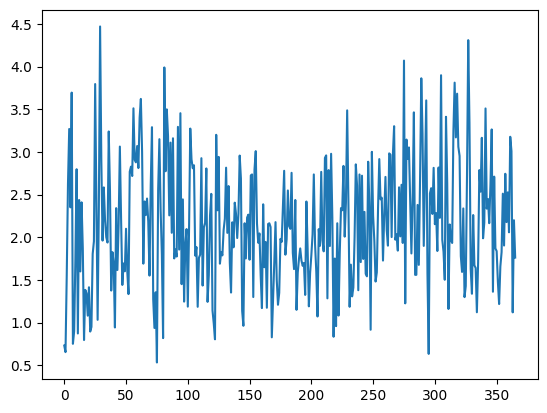

In [19]:
plt.plot(np.arange(366), MAE)

### THIS IS NOT BAD, BETTER THAN THE BI-DAILY MODELS BUT WORSE THAN DAILY ONES, WITH THIS IT IS NOT NECESSARY TO TRAIN A NEW GP FOR EVERY DAY

### TRY THIS ON DATA UNSEEN BY THE HMM

In [20]:
#this find the most probable state based on observed temperature
Z = model_hmm[best_bic].predict(test_hmm[train_feature_hmm].values) 

for i in range(len(train_gp_unknown_state)):
    train_gp_unknown_state[i].insert(11, "state", Z)

#insert the state column
for i in range(len(test_gp_unknown_state)):
    test_gp_unknown_state[i].insert(11, "state", Z)
    
#performance check by using GP based on state, use one year of the test data
MAE=[]
for i in tqdm(range(366)):
    #create the train set
    train=[]
    for j in range(len(train_gp_unknown_state)):
        train.append(train_gp_unknown_state[j].loc[i:i,:])
    train=pd.concat(train)
    
    #create test set
    test=[]
    for j in range(len(test_gp_unknown_state)): 
        test.append(test_gp_unknown_state[j].loc[i:i,:])
    test=pd.concat(test)
    
    model=gp_model_states[train["state"].values[0]]#select model based on state
    
    mean, var = model.predict_f(test[train_feature].values)     
    #compute the MAPE
    MAE.append(np.abs(test[target_feature].values-np.array(mean)).mean())

100%|█████████████████████████████████████████| 366/366 [00:24<00:00, 15.00it/s]


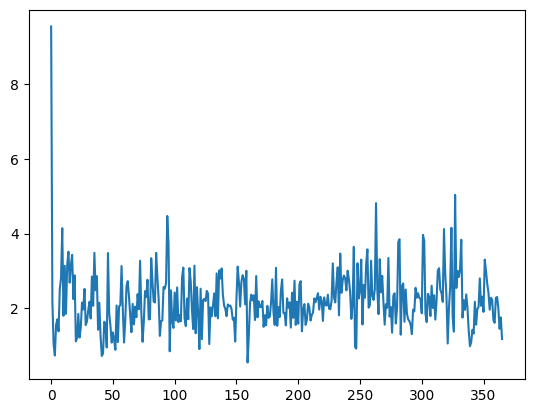

In [21]:
plt.plot(np.arange(366), MAE)

### STILL GOOD, EXCEPT THE FIRST DAY IN WHICH THE STATE CHOSEN IS WRONG

### USING OTHER TRAINING FEATURES IT WOULD BE POSSIBLE TO IDENTIFY MORE COMPLEX STATES, AND POSSIBLY ALSO INCLUDE WEATHER INFORMATION IN GP TRAINING, BUT OTHER VARIABLES PROBABLY CHANGE TOO MUCH ACROSS THE AREA, SO A SINGLE STATE FOR THE WHOLE ARE WOULD NOT BE ACCURATE.

### TRY THE SAME USING OTHER VARIABLES (WITHOUT TEMPERATURE INFORMATION) 


In [8]:
#Put all data, about some weather variables,together
#have to reduce the number of columns, use less stations
new_train_stations_list=list(set(train_stations_list)-set([5]))
weather_df=[]
for i in new_train_stations_list:
#    if i%4==0: continue #for a dimensionality reduction
    weather_df.append(data[i][["Relative Humidity", "Wind Speed", "Precipitation", "Cloud Cover"]])
weather_df=pd.concat(weather_df, axis=1)

weather_df

Relative Humidity  Wind Speed  Precipitation  Cloud Cover  \
0                 90.62         8.9      -4.605170         71.6   
1                 89.80         8.8      -4.605170         74.1   
2                 93.01         8.7      -4.605170         94.5   
3                 87.73         7.0      -4.605170         96.6   
4                 83.54         8.0      -4.605170         61.1   
...                 ...         ...            ...          ...   
4013              96.34        11.0       2.564949         42.0   
4014              88.39        14.5      -4.605170         31.0   
4015              88.70        10.2       0.048790         41.2   
4016              91.66        10.9       1.098612         42.0   
4017              89.17        25.1      -4.605170         36.9   

      Relative Humidity  Wind Speed  Precipitation  Cloud Cover  \
0                 98.79        15.4      -4.605170          5.2   
1                 94.11        18.0      -4.605170         10.0   
2                 98.96         7.2       1.947338         68.7   
3                 99.36         7.2      -4.605170         64.0   
4                 99.31        10.8      -4.605170         61.8   
...                 ...         ...            ...          ...   
4013              99.98        28.6      -1.771957         83.1   
4014              99.96        14.3       0.698135         83.1   
4015              99.96        17.9      -0.843970         83.1   
4016              99.98        10.7       2.913437         83.1   
4017              98.90        10.8      -4.605170         64.9   

      Relative Humidity  Wind Speed  ...  Precipitation  Cloud Cover  \
0                 98.87         7.6  ...      -4.605170         20.8   
1                 98.64         7.9  ...      -4.605170         16.7   
2                 99.98         9.3  ...       1.033184         86.6   
3                 94.89         5.8  ...      -4.605170         41.9   
4                 90.08        15.1  ...      -4.605170         70.6   
...                 ...         ...  ...            ...          ...   
4013              96.69        13.8  ...       2.562639         83.3   
4014              96.28        17.1  ...       0.693147         33.7   
4015              95.11        23.0  ...      -0.798508         83.3   
4016              98.49        16.1  ...       0.891998         82.9   
4017              95.16        18.4  ...      -4.605170         73.2   

      Relative Humidity  Wind Speed  Precipitation  Cloud Cover  \
0                 70.92        32.4      -4.605170         10.8   
1                 65.17        25.2      -4.605170         25.0   
2                 76.81        18.0      -4.605170         84.6   
3                 75.41        10.8      -4.605170         82.9   
4                 89.65        10.8      -2.207275         87.5   
...                 ...         ...            ...          ...   
4013              97.75         5.7       2.639771        100.0   
4014              97.73         3.6       1.068153         79.1   
4015              98.57         3.6       3.149740        100.0   
4016              95.13         7.2      -0.494296         74.5   
4017              97.94         7.2       2.307573         89.1   

      Relative Humidity  Wind Speed  Precipitation  Cloud Cover  
0                 88.62        14.6      -4.605170         27.2  
1                 85.59        12.7      -4.605170         11.6  
2                 92.11        22.6       0.788457         87.4  
3                 88.53        19.0      -2.302585         14.8  
4                 93.73         7.3      -0.967584         47.4  
...                 ...         ...            ...          ...  
4013              95.56        23.7       1.124930         78.2  
4014              92.71        25.2       0.392042         71.4  
4015              91.52        14.7      -2.120264         78.7  
4016              93.65        21.9       0.810930         75.6  


In [9]:
#use first 8? years to train 
train_hmm=weather_df.loc[0:365*4,:]
#train=pd.concat(train)

test_hmm=weather_df.loc[365*4:365*5,:].reset_index()
#test=pd.concat(test)
train_feature_hmm=weather_df.columns.to_list()

In [93]:
model_hmm=[]  #list of models, the number of hidden states is different
hidden_states=[1,2,3,4,5,6,10,15,20] #number of hidden states to try

#relax conditions a little bit
for i in hidden_states:
    model_hmm.append(hmm.GaussianHMM(n_components=i, n_iter=200, random_state=42, covariance_type = "diag", tol=1e-2))
    
#fit the models
for i in tqdm(range(len(model_hmm))):
    model_hmm[i].fit(train_hmm[train_feature_hmm].values)

100%|█████████████████████████████████████████████| 9/9 [01:37<00:00, 10.83s/it]


### IN MANY CASES THE MODEL STRUGGLE TO CONVERGE, PROBABLY FOR THE REASON MENTIONED ABOVE.

In [94]:
#run only once to save the models
#file_path = 'gaussianhmm_process_various_state.pickle'
# Open the file in binary mode
#with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
#    pickle.dump(model_hmm, file)

In [10]:
file_path = 'gaussianhmm_process_various_state.pickle'
# Open the file in binary mode
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    model_hmm = pickle.load(file)

In [11]:
hidden_states=[1,2,3,4,5,6,10,15,20] #number of hidden states to try
aic=[]
bic=[]
for i in range(len(model_hmm)):
    aic.append(model_hmm[i].aic(train_hmm[train_feature_hmm].values))
    bic.append(model_hmm[i].bic(train_hmm[train_feature_hmm].values))

best_aic=np.argmin(aic)
best_bic=np.argmin(bic)
print(f'Best number of hidden states according to AIC {hidden_states[best_aic]}')
print(f'Best number of hidden states according to BIC {hidden_states[best_bic]}')

Best number of hidden states according to AIC 20
Best number of hidden states according to BIC 20



Model convergence:
True

Gaussian distribution means:
[[72.55 84.61 77.28 ... 54.7  66.23 68.68]
 [59.4  56.8  58.14 ... 16.97 11.72 17.36]
 [82.54 94.27 86.24 ... 84.09 83.87 82.24]
 ...
 [90.03 93.5  94.5  ... 82.79 79.4  86.16]
 [70.32 67.21 70.7  ... 29.81 21.89 30.57]
 [73.21 83.52 73.5  ... 52.01 31.65 67.43]]

Start probabilities:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Transition matrix:
[[0.32 0.   0.05 0.   0.12 0.03 0.03 0.   0.1  0.   0.07 0.   0.1  0.07
  0.   0.   0.12 0.   0.   0.  ]
 [0.   0.63 0.   0.03 0.   0.02 0.   0.11 0.   0.   0.   0.07 0.   0.09
  0.   0.01 0.02 0.   0.02 0.  ]
 [0.06 0.   0.39 0.   0.   0.   0.12 0.   0.06 0.   0.09 0.   0.12 0.
  0.   0.   0.06 0.09 0.   0.  ]
 [0.   0.27 0.   0.27 0.   0.11 0.   0.03 0.   0.08 0.   0.   0.   0.11
  0.   0.   0.11 0.   0.   0.03]
 [0.06 0.   0.   0.   0.49 0.12 0.   0.   0.   0.05 0.07 0.   0.12 0.
  0.01 0.02 0.06 0.   0.   0.  ]
 [0.   0.   0.   0.13 0.09 0.3  0.   0.   0.   0.06 0.04

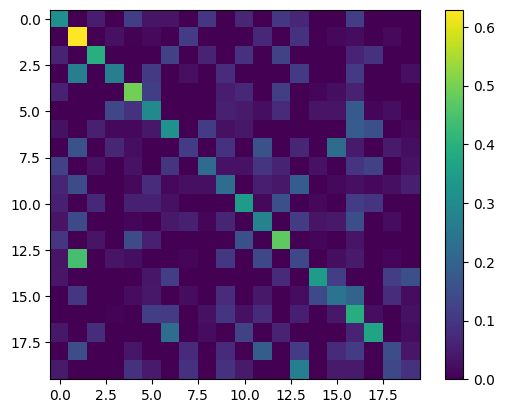

In [12]:
print("\nModel convergence:")
print(model_hmm[best_bic].monitor_.converged) 


print("\nGaussian distribution means:")
print(np.round(model_hmm[best_bic].means_, 2))

#print("\nGaussian distribution covariances:")
#print(np.round(model_hmm[best_bic].covars_, 2))

print("\nStart probabilities:")
print(np.round(model_hmm[best_bic].startprob_, 2))

print("\nTransition matrix:")
print(np.round(model_hmm[best_bic].transmat_,2))

_ = plt.imshow(model_hmm[best_bic].transmat_)
_ = plt.colorbar()

### DEFINE A DIFFERENT MODEL FOR EACH STATE, SEE IF IT CAN BE USED TO MAKE INTERPOLATION

In [13]:
#These are the most probable hidden states sequence of train set, and simulated hidden states sequence of test set
Z = model_hmm[best_bic].predict(train_hmm[train_feature_hmm].values) # Find most probable hidden states sequence
Z_prob = model_hmm[best_bic].predict_proba(train_hmm[train_feature_hmm].values) # Find most probable hidden states sequence
#X_sim, Z_sim = model_hmm[best_bic].sample(sim_len, currstate=np.random.choice(np.arange(hidden_states[best_bic]), p=Z_prob[-1]))

In [15]:
#divide in new train and test for gp 

#create the train/test dataframes with first day
train_gp_known_state=[]
train_gp_unknown_state=[]
for i in new_train_stations_list:
    train_gp_known_state.append(data[i].loc[:365*4,:]) 
    train_gp_unknown_state.append(data[i].loc[365*4:365*5,:].reset_index())
#train=pd.concat(train)

#insert the state column
for i in range(len(train_gp_known_state)):
    train_gp_known_state[i].insert(11, "state", Z)

test_gp_known_state=[]
test_gp_unknown_state=[]
for i in test_stations_list:
    test_gp_known_state.append(data[i].loc[:365*4,:].reset_index())
    test_gp_unknown_state.append(data[i].loc[365*4:365*5,:].reset_index())
#test=pd.concat(test)

#insert the state column
for i in range(len(test_gp_known_state)):
    test_gp_known_state[i].insert(11, "state", Z)

In [16]:
#this will train a different gp for each state
import gpflow
from gpflow.kernels import RBF, Periodic, Coregion, Matern12, Cosine, White, Linear, Matern52, RationalQuadratic, Matern32


def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="L-BFGS-B",
        options={"disp": 0, "maxiter": 150},   
    )


gp_model_states=[]
STATES = np.unique(Z)
#select the first state found to train a model
for j in tqdm(STATES):
    train=[]
    for i in range(len(train_gp_known_state)):
        train.append(train_gp_known_state[i][train_gp_known_state[i]['state']==j].head(1))
    train=pd.concat(train)

    train_feature=["Latitude", "Longitude"] #"Wind Speed", "Sea Level Pressure"]#, "Latitude", "Longitude"]
    target_feature=["Minimum Temperature"]


    #Define the temporal kernel 

    space_kernel1=Linear()
    #space_kernel2=Matern32()
    space_kernel3=RationalQuadratic()
    
    space_kernel_tot=space_kernel1+space_kernel3#+space_kernel3
    noise=White(variance=0.3**2)
    #Composite kernel
    kernel = (space_kernel_tot+noise) 
    model = gpflow.models.GPR((train[train_feature].values, train[target_feature].values), kernel=kernel)
    #Optimize the model
    optimize_model_with_scipy(model)
    gp_model_states.append(model)

2024-08-21 18:43:15.398413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 18:43:16.799525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|███████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]


In [17]:
#performance check by using GP based on state, use one year of the training data of the hmm
MAE=[]
for i in tqdm(range(366)):
    #create the train set
    train=[]
    for j in range(len(train_gp_known_state)):
        train.append(train_gp_known_state[j].loc[i:i,:])
    train=pd.concat(train)
    
    #create test set
    test=[]
    for j in range(len(test_gp_known_state)): 
        test.append(test_gp_known_state[j].loc[i:i,:])
    test=pd.concat(test)
    
    model=gp_model_states[train["state"].values[0]]#select model based on state
    
    mean, var = model.predict_f(test[train_feature].values)     
    #compute the MAPE
    MAE.append(np.abs(test[target_feature].values-np.array(mean)).mean())

100%|█████████████████████████████████████████| 366/366 [00:26<00:00, 13.94it/s]


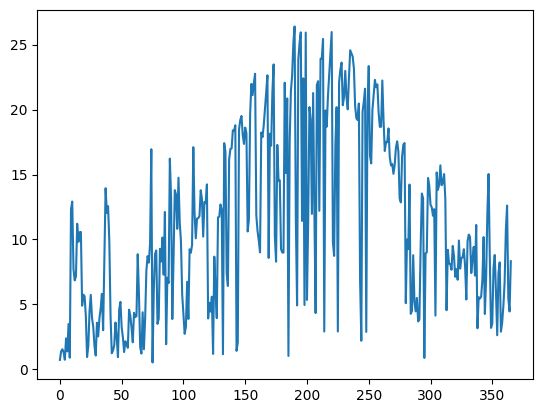

In [18]:
plt.plot(np.arange(366), MAE)

### VERY BAD, WITH THIS WEATHER VARIABLES A HIDDEN STATE FOR THE WHOLE REGION IS NOT OK, THE VARIABLES ARE TOO DIFFERENT ACROSS THE REGION.